# Binary Classifier for Water Quality Prediction

**Pierrot Van der Aa**

**October 2023**

This analysis is based on the water quality kaggle dataset which can be found at https://www.kaggle.com/datasets/mssmartypants/water-quality

This script was made based on the sci-kit learn documentation and with the help of the following [video](https://youtu.be/q90UDEgYqeI).

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#Load the data
data = pd.read_csv("/home/pierrot/pCloudDrive/Mabisbis/Thesis/Binary_Classifier/Train_set.csv", header = 0)
data.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,4.98,5.95,0.37,2.64,0.02,7.75,0.40,1.64,0.29,0.0,...,0.001,15.23,2.02,0.005,36.32,2.18,0.05,0.19,0.04,0
1,4.92,25.55,0.59,3.68,0.06,0.64,0.48,1.39,0.70,0.0,...,0.001,13.57,1.15,0.006,12.87,6.88,0.05,0.07,0.07,0
2,1.53,28.25,0.16,4.29,0.12,2.04,0.27,0.97,0.06,0.0,...,0.001,3.11,1.29,0.008,44.17,4.29,0.07,0.31,0.08,0
3,3.56,11.52,0.45,1.27,0.01,5.10,0.46,0.40,0.79,0.0,...,0.001,14.38,1.13,0.006,30.27,5.75,0.04,0.35,0.02,0
4,3.74,17.45,0.78,2.04,0.02,4.30,0.62,0.59,0.05,0.0,...,0.001,7.41,1.12,0.008,56.41,4.77,0.04,0.43,0.08,0


In [4]:
#Split the data into data and predictions
X = data.drop("is_safe", axis=1).copy()
y = data["is_safe"].copy()

In a first time, we will do a classical attempt with a training and validation set. The cross-validation will come in a later time as I expect it to be more complicated to implement.

In [5]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=42)

In [6]:
#Create a decision tree fitted to the data
tree = DecisionTreeClassifier(random_state=42)
tree = tree.fit(X_train, y_train)

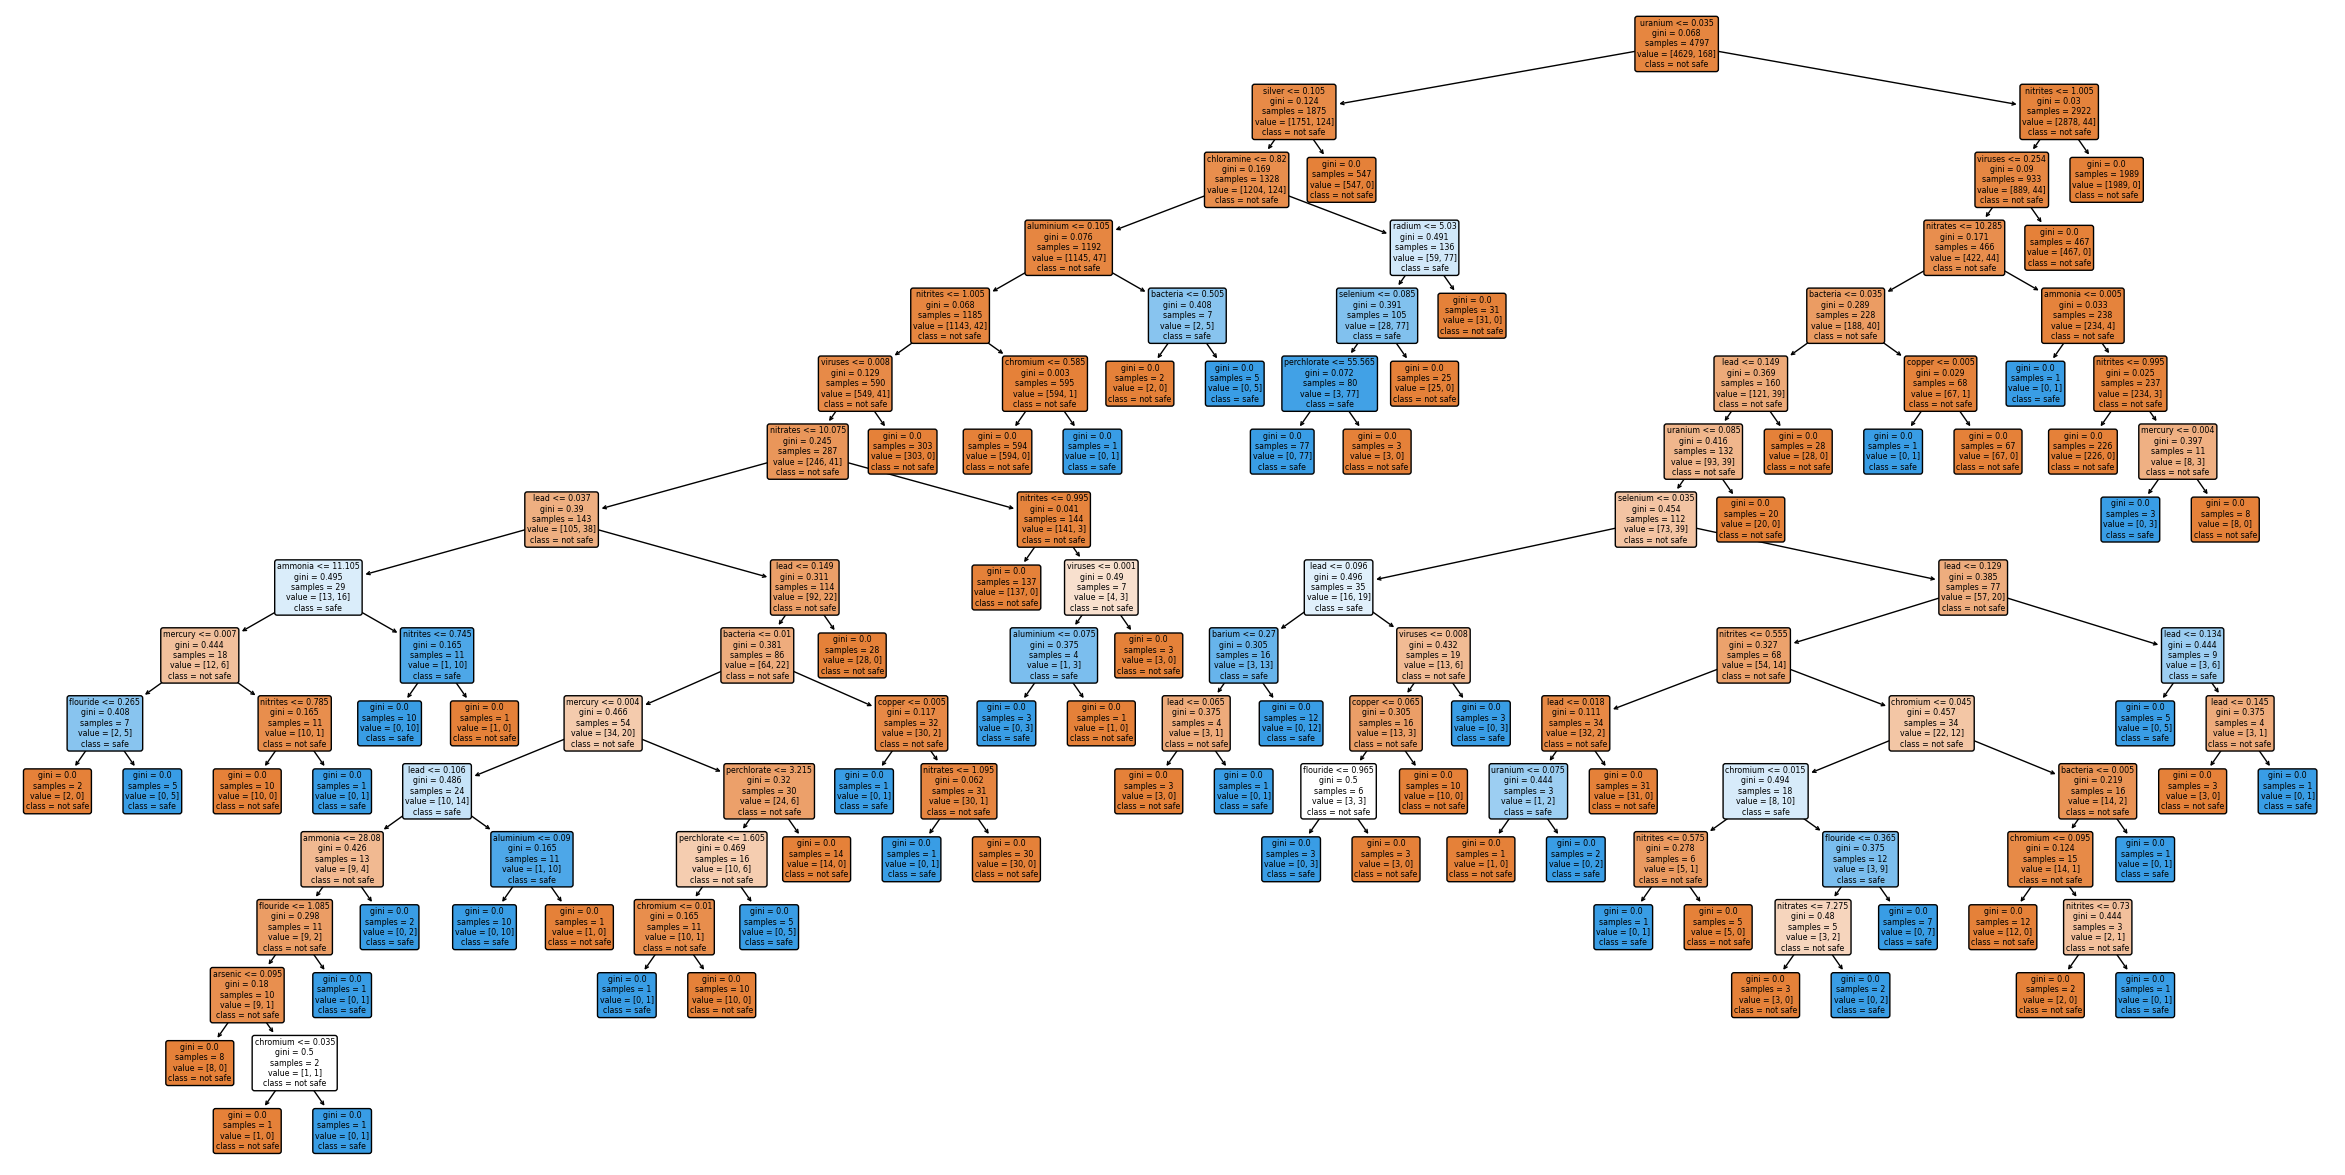

In [7]:
#First plot of the raw tree
plt.figure(figsize=(30, 15))
plot_tree(tree,
          filled=True,
          rounded=True,
          class_names=["not safe", "safe"],
          feature_names=list(X.columns));

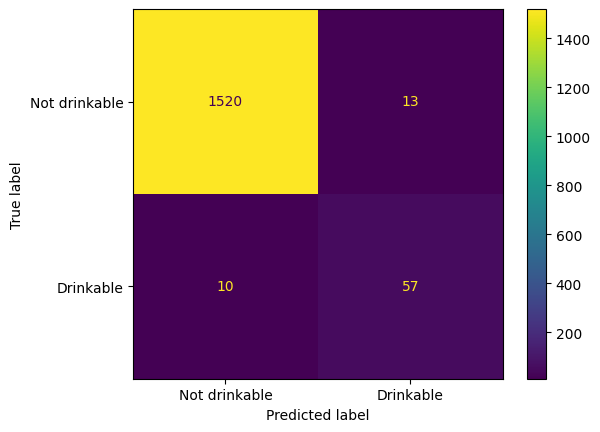

In [8]:
#Plot the confusion matrix which highlights a high class imbalance
ConfusionMatrixDisplay.from_estimator(tree,X_val,y_val,display_labels=["Not drinkable", "Drinkable"])

We now have our first draft tree that is overfitting the data. We need to prune it to make it more flexible which in turn will allow better predictions on the validation set.

In order to do that, we produce a tree for each value of alpha, parameter for controling the tree pruning. We then score and compare all the trees produced.

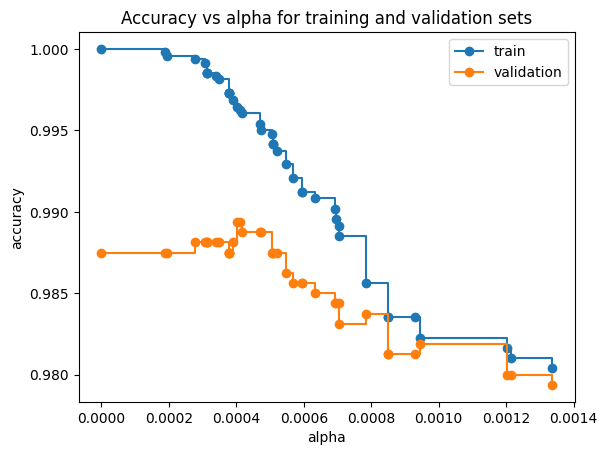

In [15]:
#Create a list of values for alpha
path = tree.cost_complexity_pruning_path(X_train, y_train)
pruning_alphas = path.ccp_alphas
pruning_alphas = pruning_alphas[:-1] #to avoid having a tree with only a root

#Create a list of trees for each values of alpha
trees_alpha = []
for pruning_alpha in pruning_alphas:
    tree_alpha = DecisionTreeClassifier(random_state=0, ccp_alpha=pruning_alpha)
    tree_alpha.fit(X_train, y_train)
    trees_alpha.append(tree_alpha)

#Plot
train_scores = [tree_alpha.score(X_train, y_train) for tree_alpha in trees_alpha]
val_scores = [tree_alpha.score(X_val, y_val) for tree_alpha in trees_alpha]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(pruning_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(pruning_alphas, val_scores, marker="o", label="validation", drawstyle="steps-post")
ax.legend()

In [10]:
#Print the values of alpha to see which one is the optimal based on the graph
print(pruning_alphas)

[0.         0.00018762 0.00019457 0.00027795 0.00030701 0.0003127
 0.0003127  0.0003127  0.00034049 0.00034744 0.00037902 0.00037902
 0.00037902 0.00037902 0.00039087 0.00040204 0.0004108  0.00041623
 0.00046904 0.00047232 0.00050685 0.00050813 0.00050999 0.00052116
 0.00054656 0.00056748 0.00059561 0.00059561 0.00063391 0.00069307
 0.00069534 0.00070356 0.00070358 0.00078466 0.0008488  0.0008493
 0.00093033 0.00094364 0.00120388 0.00121417 0.00133702]


From the graph and the list of values of alpha, the closest value of alpha to the optimal one is 0.00041623. We now need to refine our analysis to find the exact value of alpha for the optimal tree. For that purpose we will use cross-validation.

<Axes: xlabel='tree'>

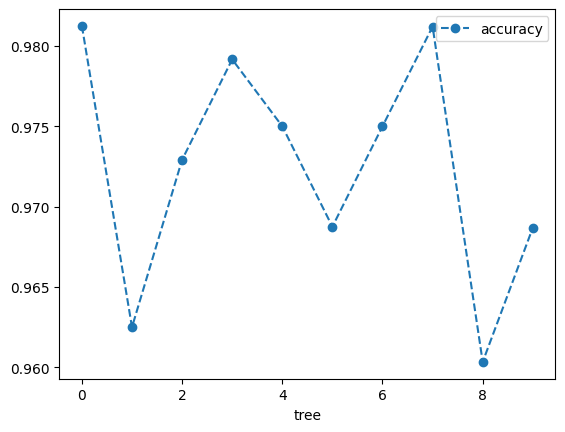

In [11]:
tree_bis = DecisionTreeClassifier(random_state=42, ccp_alpha=0.00041623)

scores = cross_val_score(tree_bis, X_train, y_train, cv=10) #ten fold cross-validation
df = pd.DataFrame(data={'tree': range(10), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

The latter graph highlights that the accuracy vary for different subsets training-validation for a same value of alpha.

<Axes: xlabel='alpha'>

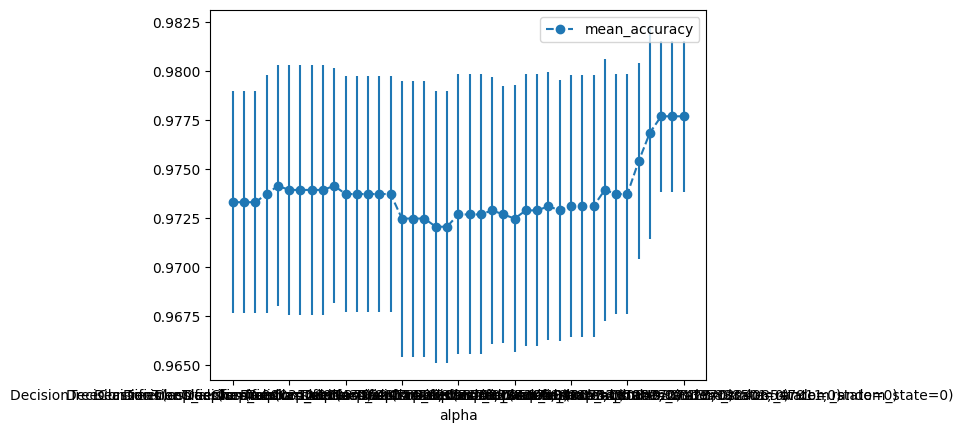

In [12]:
alpha_loop = []
for pruning_alpha in pruning_alphas:
    tree_alpha = DecisionTreeClassifier(random_state=0, ccp_alpha=pruning_alpha)
    scores = cross_val_score(tree_alpha, X_train, y_train, cv=10)
    alpha_loop.append([tree_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop, columns=["alpha", "mean_accuracy", "std"])

alpha_results.plot(x="alpha",
                   y="mean_accuracy",
                   yerr="std",
                   marker='o',
                   linestyle='--')

In [13]:
alpha_results.tail()

,alpha,mean_accuracy,std
36,DecisionTreeClassifier(ccp_alpha=0.00093033384...,0.975401,0.005004
37,DecisionTreeClassifier(ccp_alpha=0.00094364097...,0.976859,0.005396
38,DecisionTreeClassifier(ccp_alpha=0.00120387742...,0.977693,0.003856
39,DecisionTreeClassifier(ccp_alpha=0.00121417274...,0.977693,0.003856
40,DecisionTreeClassifier(ccp_alpha=0.00133702240...,0.977693,0.003856


We can see on the graph and in the dataframe here above that the optimal value of alpha is somewhere higher than 0.0012. Therefore, in order to fit the test set as best as possible, we will prune the tree as much as possible and take the more extreme value of alpha.

In [13]:
#Making the final pruned tree with the best value for alpha
tree_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=0.00133702240)
tree_pruned = tree_pruned.fit(X_train, y_train)

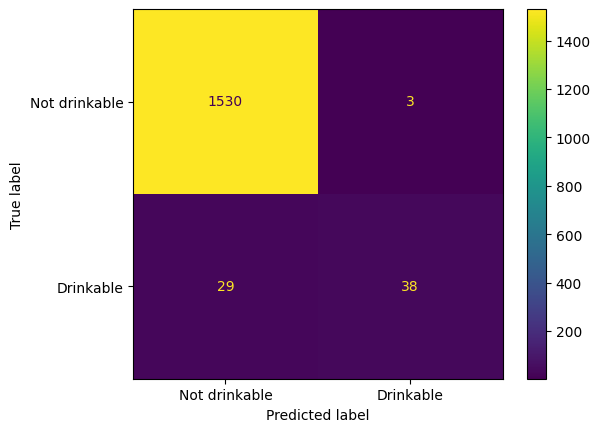

In [14]:
#Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(tree_pruned,X_val,y_val,display_labels=["Not drinkable", "Drinkable"])

There are still a lot of data predicted as not drinkable while they are drinkable but that's because of the high class imbalance.

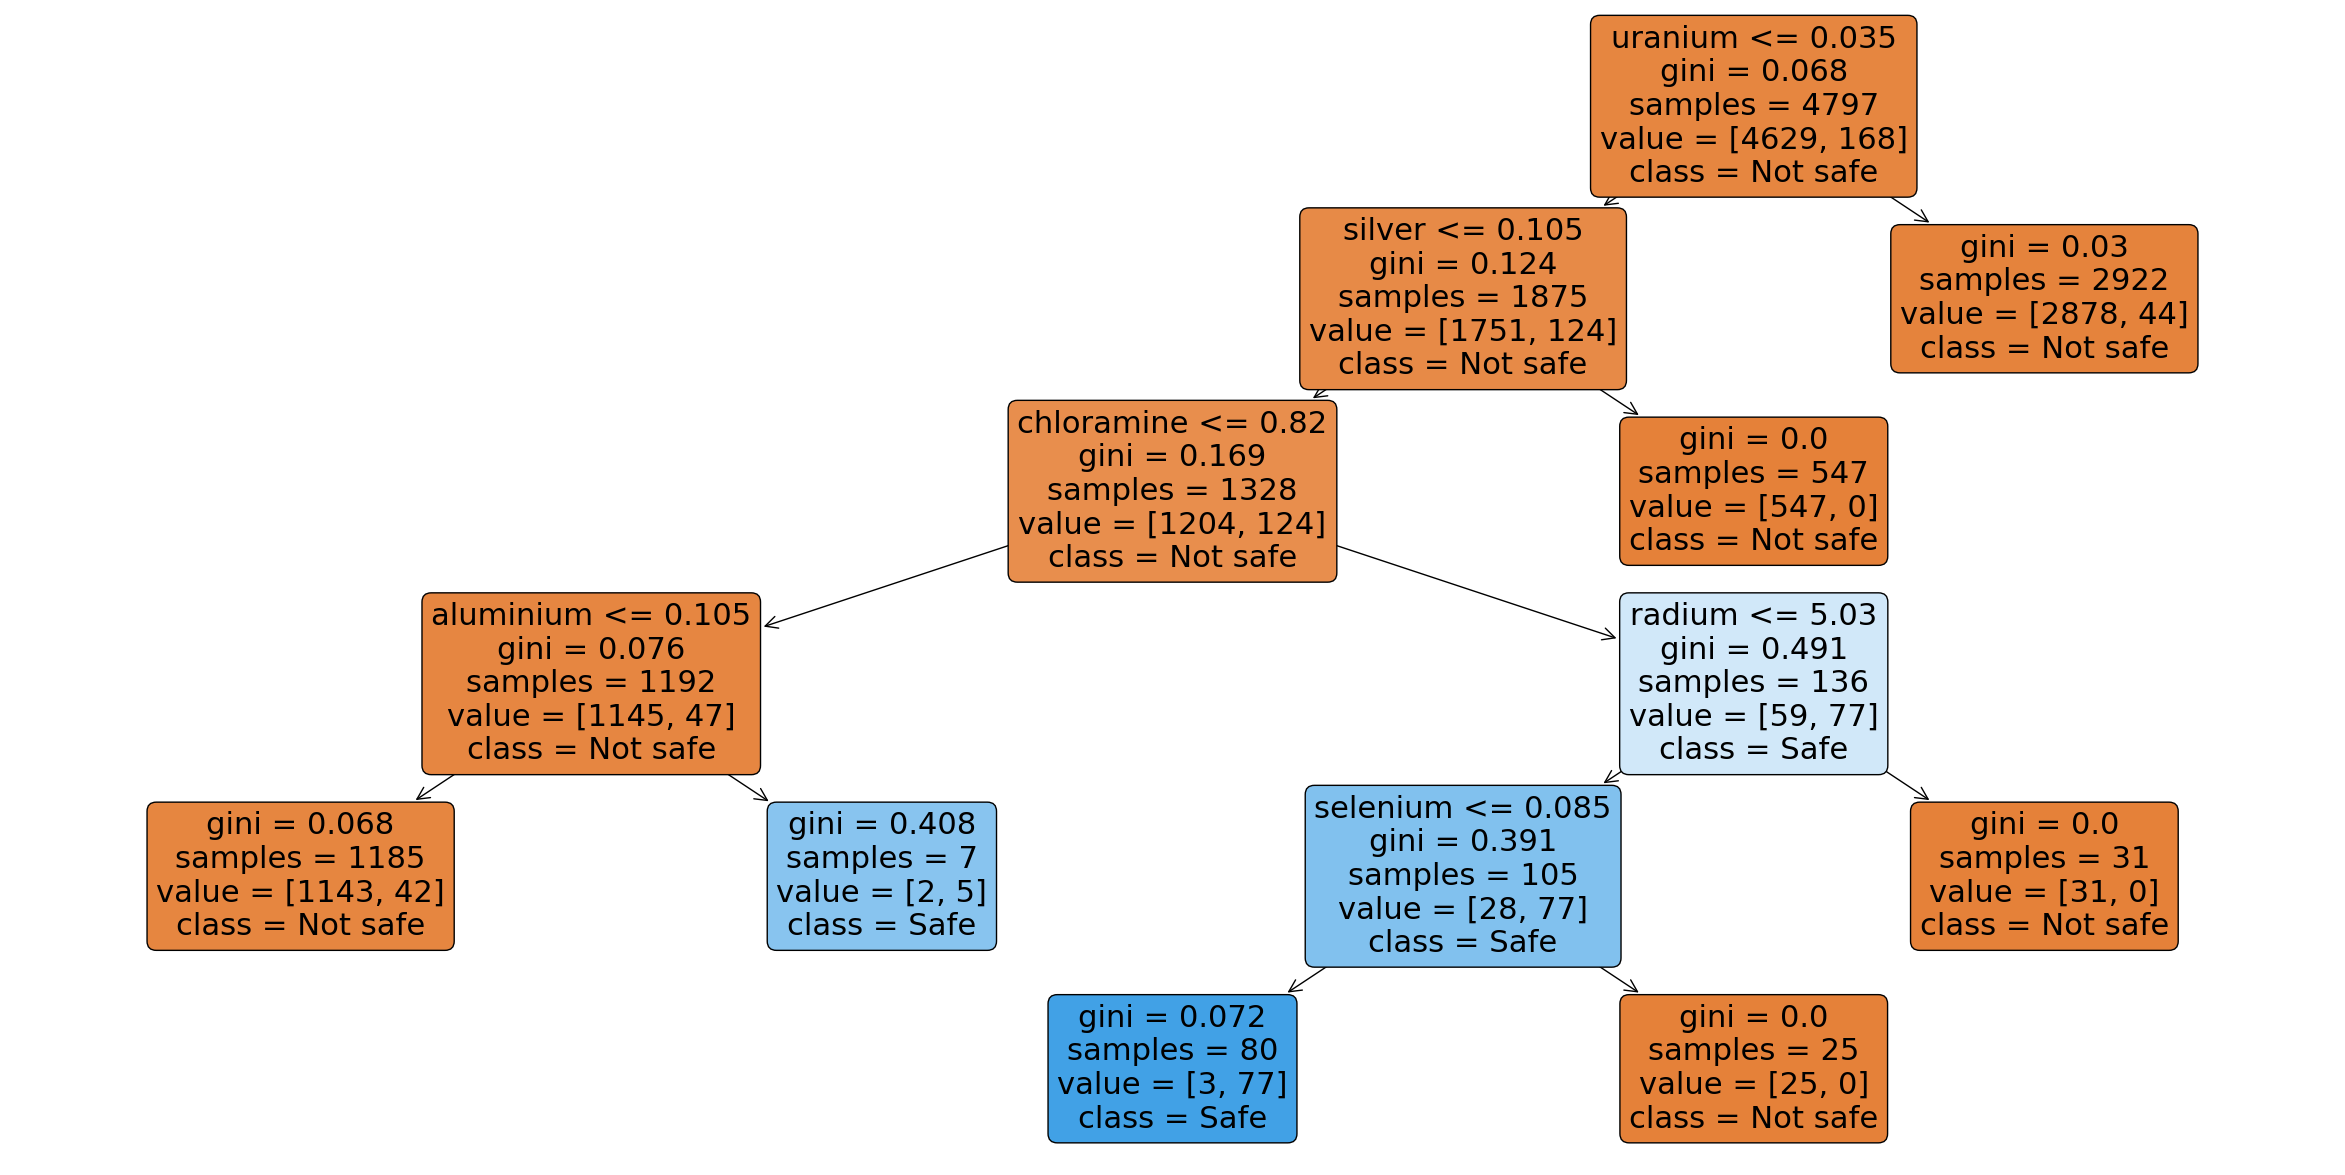

In [15]:
plt.figure(figsize=(30, 15))
plot_tree(tree_pruned,
          filled=True,
          rounded=True,
          class_names=["Not safe", "Safe"],
          feature_names=list(X_train.columns));

We can now apply our final pruned tree to the test set.


/home/pierrot/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


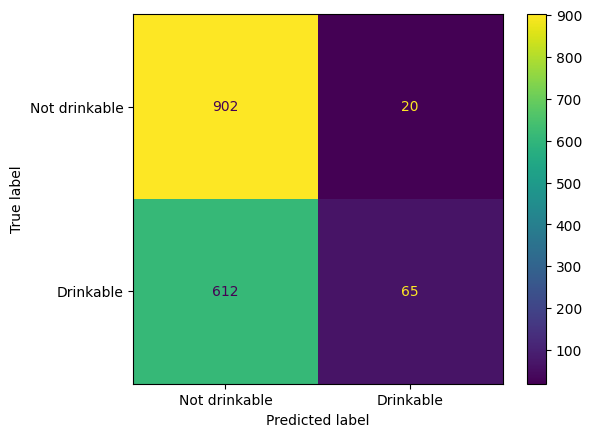

In [25]:
#Load the data
test = pd.read_csv("/home/pierrot/pCloudDrive/Mabisbis/Thesis/Binary_Classifier/Test_set.csv", header = None)
test.head()
X_test = test.drop(20, axis=1).copy()
y_test = test[20].copy()

#Create the confusion matrix
ConfusionMatrixDisplay.from_estimator(tree_pruned,X_test,y_test,display_labels=["Not drinkable", "Drinkable"])

## Conclusion

It seems that there's a strong class imbalance both in the train set and in the test set but in different directions. In the training set, most of the data are labelled as not drinkable. Therefore, the algorithm consider that most of the time, a sample is more likely to be labelled as "not drinkable". This results in a high number of mislabbelled item in the test set which are counted as not drinkable when they are in fact drinkable.